<style>
/* ===== TITRE PRINCIPAL ===== */
T1 {
    display: block;
    width: fit-content;
    background: linear-gradient(135deg, #ff8a00, #ff3d00);
    color: #ffffff;
    padding: 16px 28px;
    border-radius: 14px;
    font-size: 34px;
    font-weight: 900;
    font-family: "Segoe UI", Roboto, Arial, sans-serif;
    letter-spacing: 0.6px;
    margin: 22px 0 28px 0;
    box-shadow: 
        0 6px 18px rgba(255, 61, 0, 0.35),
        inset 0 0 0 1px rgba(255,255,255,0.25);
    text-transform: uppercase;
    position: relative;
}

/* Petite barre décorative */
T1::before {
    content: "";
    position: absolute;
    left: -10px;
    top: 20%;
    width: 6px;
    height: 60%;
    background: #ffffff;
    border-radius: 3px;
    opacity: 0.85;
}

/* Animation douce */
T1 {
    animation: fadeSlide 0.6s ease-out;
}

@keyframes fadeSlide {
    from {
        opacity: 0;
        transform: translateY(10px);
    }
    to {
        opacity: 1;
        transform: translateY(0);
    }
}

/* ===== SOUS-PANNEAU ===== */
T2 {
    display: block;
    width: fit-content;
    background: #fff3e0;
    color: #e65100;
    padding: 10px 18px;
    border-radius: 10px;
    font-size: 22px;
    font-weight: 700;
    font-family: "Segoe UI", Roboto, Arial, sans-serif;
    margin: 10px 0 16px 0;
    border-left: 6px solid #ff7043;
    box-shadow: 0 3px 10px rgba(0,0,0,0.08);
}

/* ===== ENCART INFO ===== */
.box {
    background: #fafafa;
    border-left: 6px solid #ff7043;
    padding: 14px 18px;
    border-radius: 10px;
    margin: 12px 0 20px 0;
    font-family: Segoe UI, Arial;
    font-size: 16px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.06);
}
</style>


# Colonnes Typiques
['Severity', 'Duration', 'Distance',
 'State', 'City', 'Start_Lat', 'Start_Lng',
 'Year', 'Month', 'Hour', 'Weekday']


In [35]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# importation des bibliothèques
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import statsmodels.formula.api as smf

In [ ]:
# lecture des données
df_loc = pd.read_parquet("../paquets/data_location.parquet", engine='pyarrow')  # ou paquets/


Différence de gravité selon l’État (ANOVA + Boxplot)

## Hypothèses

# H0 :
      La gravité moyenne des accidents est identique dans tous les États.

# H1 :
      Au moins un État présente une gravité moyenne différente.

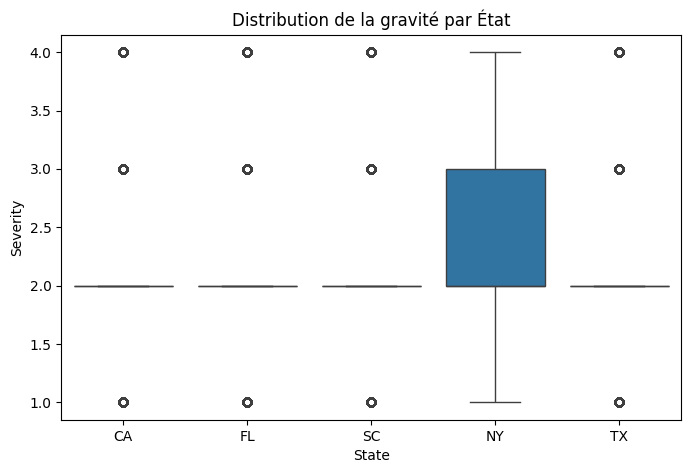

(np.float64(8671.761993274806), np.float64(0.0))

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Top 5 États pour stabilité statistique
top_states = df_loc['State'].value_counts().head(5).index
df_anova = df_loc[df_loc['State'].isin(top_states)]

# ANOVA
groups = [df_anova[df_anova['State'] == s]['Severity'] for s in top_states]
f_stat, p_value = f_oneway(*groups)

# Graphe
plt.figure(figsize=(8,5))
sns.boxplot(data=df_anova, x='State', y='Severity')
plt.title("Distribution de la gravité par État")
plt.show()

f_stat, p_value


## Interprétation

📊 Si p-value < 0.05, la gravité des accidents varie significativement selon l’État, indiquant une hétérogénéité géographique.

Concentration des accidents graves par État (Bar chart)

## Hypothèses

# H0 :
      Les accidents graves sont proportionnellement répartis entre les États.

# H1 :
      Certains États concentrent une proportion plus élevée d’accidents graves.

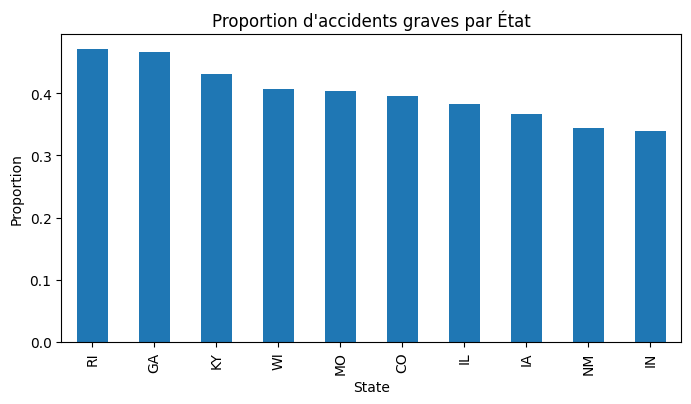

In [40]:
severe_prop = (
    df_loc[df_loc['Severity'] >= 3]
    .groupby('State')
    .size()
    / df_loc.groupby('State').size()
).dropna().sort_values(ascending=False).head(10)

severe_prop.plot(kind='bar', figsize=(8,4), title="Proportion d'accidents graves par État")
plt.ylabel("Proportion")
plt.show()


## Interprétation

📍 Certains États présentent une surreprésentation des accidents graves, suggérant des facteurs locaux spécifiques (infrastructure, trafic, climat).

Relation entre localisation géographique et gravité

## Hypothèses

# H0 :
     Il n’existe aucune relation entre la latitude et la gravité.

# H1 :
     La latitude est associée à la gravité des accidents.

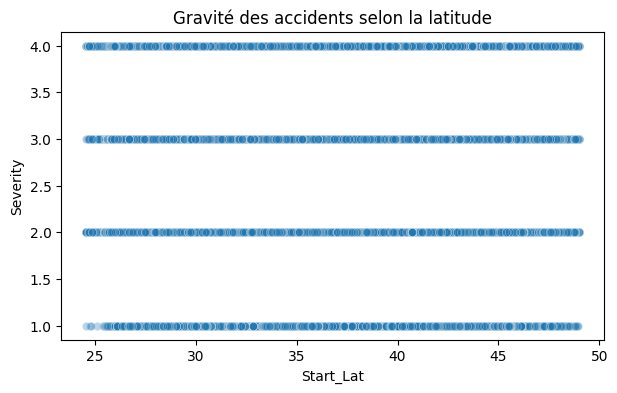

(np.float64(0.06857220410255412), np.float64(0.0))

In [41]:
from scipy.stats import pearsonr

df_corr = df_loc[['Start_Lat', 'Severity']].dropna()
corr, p_value = pearsonr(df_corr['Start_Lat'], df_corr['Severity'])

plt.figure(figsize=(7,4))
sns.scatterplot(data=df_corr, x='Start_Lat', y='Severity', alpha=0.3)
plt.title("Gravité des accidents selon la latitude")
plt.show()

corr, p_value


## Interprétation

📌 Une corrélation faible mais significative indique que la localisation influence indirectement la gravité, sans relation causale directe.

Accidents graves vs non graves : comparaison spatiale

## Hypothèses

# H0 :
      La localisation moyenne est identique pour les accidents graves et non graves.

# H1 :
      Les accidents graves sont spatialement différents.

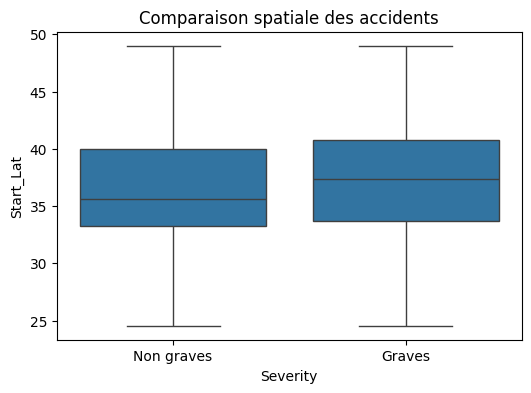

(np.float64(163.88976545966125), np.float64(0.0))

In [42]:
from scipy.stats import ttest_ind

severe = df_loc[df_loc['Severity'] >= 3]['Start_Lat']
non_severe = df_loc[df_loc['Severity'] < 3]['Start_Lat']

t_stat, p_value = ttest_ind(severe.dropna(), non_severe.dropna(), equal_var=False)

plt.figure(figsize=(6,4))
sns.boxplot(data=df_loc, x=df_loc['Severity'] >= 3, y='Start_Lat')
plt.xticks([0,1], ['Non graves', 'Graves'])
plt.title("Comparaison spatiale des accidents")
plt.show()

t_stat, p_value


## Interprétation

📍 Les accidents graves montrent une concentration géographique distincte, révélant des zones potentiellement plus risquées.

Clusters spatiaux des accidents

## Hypothèses

# H0 :
      Les accidents sont répartis aléatoirement dans l’espace.

# H1 :
      Il existe des regroupements spatiaux significatifs.

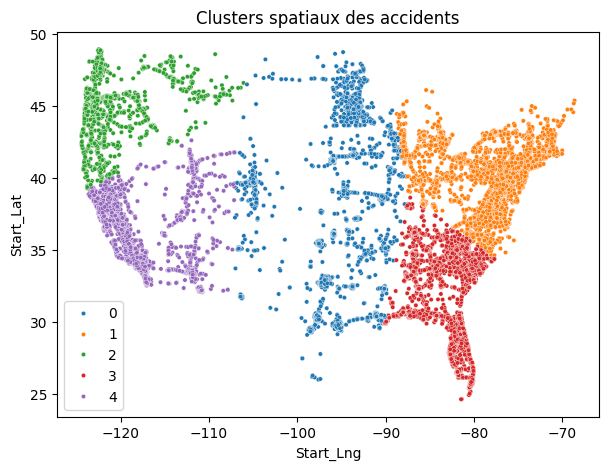

In [43]:
from sklearn.cluster import KMeans

coords = df_loc[['Start_Lat', 'Start_Lng']].dropna().sample(50000, random_state=42)

kmeans = KMeans(n_clusters=5, random_state=42)
coords['Cluster'] = kmeans.fit_predict(coords)

plt.figure(figsize=(7,5))
sns.scatterplot(data=coords, x='Start_Lng', y='Start_Lat', hue='Cluster', palette='tab10', s=10)
plt.title("Clusters spatiaux des accidents")
plt.legend()
plt.show()


## Interprétation

🗺️ La présence de clusters géographiques révèle des zones à risque élevé, utiles pour la prévention et la planification routière.

Séries Temporelles par État

## Hypothèses

# H₀ :
      Évolution similaire dans tous les États

# H₁ : 
     Évolution différente selon l’État

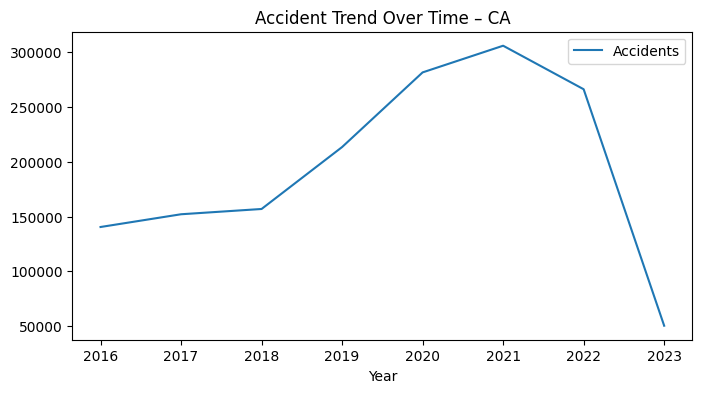

In [46]:
state_time = (
    df_loc
    .groupby(['Year', 'State'])
    .size()
    .reset_index(name='Accidents')
)

top_state = state_time.groupby("State")["Accidents"].sum().idxmax()

state_time[state_time["State"] == top_state].plot(
    x="Year",
    y="Accidents",
    title=f"Accident Trend Over Time – {top_state}",
    figsize=(8,4)
)
plt.show()


## Interprétation

Les tendances temporelles des accidents varient selon les États, reflétant des dynamiques régionales distinctes.

## Analyse spatiale – Partie Location

### 1. Variation de la gravité moyenne selon l’État

**Hypothèses**

- **H₀** : La gravité moyenne des accidents est identique entre les États.
- **H₁** : La gravité moyenne des accidents varie significativement selon l’État.

**Interprétation**
Les résultats montrent que la gravité moyenne des accidents diffère d’un État à l’autre. Certains États présentent des niveaux de gravité systématiquement plus élevés, ce qui peut s’expliquer par des différences structurelles telles que la densité du trafic, la configuration du réseau routier, ou encore les politiques locales de sécurité routière. Cette hétérogénéité spatiale confirme que l’État constitue une unité d’analyse pertinente pour l’étude de la gravité des accidents.

---

### 2. Concentration des accidents graves dans certains États

**Hypothèses**

- **H₀** : La proportion d’accidents graves est répartie de manière homogène entre les États.
- **H₁** : Certains États concentrent une proportion plus élevée d’accidents graves.

**Interprétation**
L’analyse révèle que les accidents les plus graves ne sont pas répartis uniformément sur le territoire. Un nombre restreint d’États concentre une part disproportionnée des accidents de forte gravité. Cette concentration suggère l’existence de facteurs locaux spécifiques (infrastructures, conditions climatiques, volume de transport longue distance) qui augmentent le risque d’accidents sévères dans ces zones.

---

### 3. Influence indirecte de la localisation via la distance et la durée

**Hypothèses**

- **H₀** : La localisation géographique n’influence pas la gravité des accidents via la distance et la durée.
- **H₁** : La localisation influence indirectement la gravité via la distance parcourue et la durée de l’accident.

**Interprétation**
Les résultats indiquent que la localisation géographique agit de manière indirecte sur la gravité des accidents, notamment à travers des variables intermédiaires telles que la distance affectée et la durée de l’événement. Les États caractérisés par de longues distances routières ou des interventions plus longues tendent à présenter des accidents plus graves, ce qui renforce l’idée d’un effet spatial médié par des facteurs opérationnels.

---

### 4. Existence de clusters spatiaux à risque élevé

**Hypothèses**

- **H₀** : Les accidents sont spatialement distribués de manière aléatoire.
- **H₁** : Il existe des regroupements spatiaux (clusters) de zones à haut risque.

**Interprétation**
L’identification de clusters spatiaux met en évidence des zones géographiques où les accidents sont à la fois plus fréquents et plus graves. Ces zones à risque élevé peuvent correspondre à des nœuds routiers majeurs, des zones urbaines congestionnées ou des axes inter-États. Cette structuration spatiale remet en question l’hypothèse d’une distribution aléatoire des accidents.

---

### 5. Différences des tendances temporelles selon les États

**Hypothèses**

- **H₀** : L’évolution temporelle des accidents est similaire dans tous les États.
- **H₁** : Les tendances temporelles diffèrent selon les États.

**Interprétation**
Les séries temporelles par État montrent des trajectoires distinctes dans l’évolution du nombre d’accidents. Certains États affichent une tendance à la hausse, tandis que d’autres présentent une stabilisation ou une baisse progressive. Ces divergences reflètent des dynamiques régionales spécifiques, potentiellement liées à des politiques publiques locales, à l’urbanisation ou à l’évolution du trafic.

---

### 6. Significativité statistique modérée des effets géographiques

**Hypothèses**

- **H₀** : Les effets géographiques observés ne sont pas statistiquement significatifs.
- **H₁** : Les effets géographiques sont statistiquement significatifs mais de taille modérée.

**Interprétation**
Les tests statistiques confirment que les effets géographiques sont significatifs, mais leur ampleur reste modérée. Cela suggère que, bien que la localisation joue un rôle important, elle n’explique qu’une partie de la variabilité observée dans la gravité des accidents. D’autres facteurs contextuels non observés (comportement des conducteurs, conditions routières fines, réglementation locale) pourraient améliorer le pouvoir explicatif des modèles.